## Introduction
This notebook is for clean the dataset downloaded from Lending Club website.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import time
from scipy.stats import shapiro
import statsmodels.api as sm
# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

## PreProcessing

The dataset was download from [Lending Club](https://www.lendingclub.com/statistics/additional-statistics?). It contains information from 2012 to 2019. 

**Data manipulation**: 

    - Deal with missing value 
    - check each feature
        - observe distribution 
        - Remove outliner 



In [2]:
# read data
start = time.time()
path = '/Users/cyuancheng/Documents/course/Springboard/Capstone1/data/'
df = pd.read_csv(path+'data_col_pickup.csv', low_memory=True, index_col=0, \
                 parse_dates=['issue_d', 'earliest_cr_line', 'last_pymnt_d'] )
end = time.time()
print('It takes  ' + str(end-start) +' sec to read the data')

It takes  33.15870213508606 sec to read the data


We only selected the features we plan to use. Since the goal of this project is to predict loan default with data available before the loan has been approved by Lending Club, many features could not be used by the model.

In [3]:
# check columns
print(sorted(df.columns))

['addr_state', 'annual_inc', 'delinq_2yrs', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'installment', 'int_rate', 'int_rate.1', 'issue_d', 'last_credit_pull_d', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'open_acc', 'pub_rec', 'purpose', 'recoveries', 'revol_bal', 'revol_util', 'term', 'total_pymnt', 'verification_status']


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2730228 entries, 10224583 to 158206429
Data columns (total 28 columns):
issue_d                datetime64[ns]
earliest_cr_line       datetime64[ns]
last_pymnt_d           datetime64[ns]
last_credit_pull_d     object
int_rate               float64
revol_util             float64
term                   object
grade                  object
emp_length             object
home_ownership         object
verification_status    object
loan_status            object
purpose                object
addr_state             object
loan_amnt              float64
funded_amnt            float64
installment            float64
annual_inc             float64
int_rate.1             float64
dti                    float64
revol_bal              float64
delinq_2yrs            float64
open_acc               float64
pub_rec                float64
fico_range_high        float64
fico_range_low         float64
total_pymnt            float64
recoveries             float6

In [6]:
df.drop(['int_rate.1'], axis=1, inplace=True)

In [5]:
print("Dataset has " + str(df.shape[0]) + " rows" +' and ' + str(df.shape[1]) + ' columns')

Dataset has 2730228 rows and 28 columns


## Pre-processing 

- Set loan status as target


### Target

In [7]:
df['loan_status'].value_counts(dropna=False)

Fully Paid            1346628
Current               1017832
Charged Off            327698
Late (31-120 days)      22638
In Grace Period         10754
Late (16-30 days)        4619
Default                    48
Issued                     11
Name: loan_status, dtype: int64

Majority of the data are still current (the loan still has not expired yet). Based on the definition from Lending Club below, in Grace Period, Late, Default, and Charged Off are essentially late payment in different stage (Default is late payment of 121 to 150 days and Charged Off is beyond 150 days). Here, we only focus on classifying between **Fully Paid** and **Charged Off** loan. Charged off loan means that Lending Club no longer expects the borrower to pay off the debt, which is essentially a default loan.

In [8]:
# only select either 'Fully Paid' or 'Charged Off' for Target
df = df.loc[df['loan_status'].isin(["Fully Paid", "Charged Off"])]

In [9]:
# check missing value
df['loan_status'].isnull().sum()

0

In [10]:
# check distribution for binary classification
df['loan_status'].value_counts(normalize=True)

Fully Paid     0.804281
Charged Off    0.195719
Name: loan_status, dtype: float64

It looks like the target is imbalance

Next, tag the 'Fully Paid' to 0; 'Charged Off' to 1

In [11]:
# fully paid: 0, charged off:1
df['target'] = df['loan_status'].apply(lambda x:0 if x=='Fully Paid' else 1)
df['target'].value_counts(normalize=True) 

0    0.804281
1    0.195719
Name: target, dtype: float64

### Loan terms

In [12]:
df['term_num'] = df['term'].str.extract('(\d+)',expand=False).astype(int)
df['term_num'].head(2)

id
10224583    36
10148122    36
Name: term_num, dtype: int64

### New features
New features are added: loan period, ROI

#### Loan period
calcluate the time period of the loan for each borrower
- `last payment date` minus `loan issue date`

In [13]:
df['loan_period'] = (df['last_pymnt_d'] - df['issue_d']) / np.timedelta64(1, 'M')

In [14]:
# remove loan_period = 0
df = df[df['loan_period']!=0]

(0, 0.125)

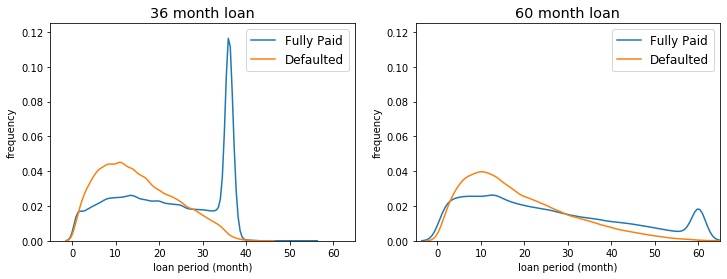

In [15]:
# compare loan period for 36 month vs 60 month loan
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12,4))
plt.rcParams.update({'font.size': 12})
sns.distplot(df[(df['target']==0) & (df['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=50, rug=False, label = 'Fully Paid', ax=ax1)
sns.distplot(df[(df['target']==1) & (df['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Defaulted', ax=ax1)

ax1.set_title('36 month loan')
ax1.set_xlabel('loan period (month)')
ax1.set_ylabel('frequency')
ax1.set_xlim([-5, 65])
ax1.set_ylim([0, 0.125])

sns.distplot(df[(df['target']==0) & (df['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Fully Paid', ax=ax2)
sns.distplot(df[(df['target']==1) & (df['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Defaulted', ax=ax2)

ax2.set_title('60 month loan')
ax2.set_xlabel('loan period (month)')
ax2.set_ylabel('frequency')
ax2.set_xlim([-5, 65])
ax2.set_ylim([0, 0.125])

For borrowers who have 36 month loan, they tend to pay off at the very end of their loans.

#### Credit Period

Borrower's credit period in month
Months difference between earliest credit line and loan issue date


In [16]:
df['credit_period'] = (df['issue_d'] - df['earliest_cr_line'])/ np.timedelta64(1, 'M') 

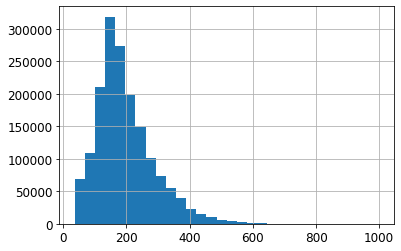

In [17]:
df['credit_period'].hist(bins=30)

#### Return on  Investment (ROI)


Next, we calculate the Return of Investment based on the following equation:
$$
\mathrm{Annual\, ROI} = \left ( \frac{p_{1}}{p_{0}} \right )^{\frac{12}{t}}  -  1
$$

$p_1$ is the total amount of loan received (total payment)

$p_0$ is the total amount committed to that loan at that point in time (funded amount)
    
$t$ is the loan period in month (loan period) - the actual number of months from the date of loan was issued to the date the last payment was made.

* this simple model does not consider reinvestiment.

This equation is similar to LC's [Net Annualized Return (NAR)](https://www.lendingclub.com/public/lendersPerformanceHelpPop.action) and a general [ROI](https://www.investopedia.com/articles/basics/10/guide-to-calculating-roi.asp) in finaincal instrument.


In [18]:
df['Annual_ROI'] = (df['total_pymnt']/df['funded_amnt'])**(12/df['loan_period'])-1

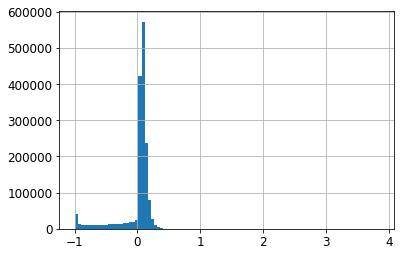

In [19]:
df['Annual_ROI'].hist(bins=100)

In [20]:
df['Annual_ROI'].describe()

count    1.661978e+06
mean    -1.379667e-02
std      2.706076e-01
min     -1.000000e+00
25%      4.047768e-02
50%      7.061541e-02
75%      1.057340e-01
max      3.837749e+00
Name: Annual_ROI, dtype: float64

### List description for each column

In [285]:
df_description = pd.read_excel('LCDataDictionary.xlsx').dropna()
df_description_pick = df_description[df_description['LoanStatNew'].isin(df.columns)]
df_description_pick.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
2,addr_state,The state provided by the borrower in the loan application
4,annual_inc,The self-reported annual income provided by the borrower during registration.
13,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
18,earliest_cr_line,The month the borrower's earliest reported credit line was opened
19,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
21,fico_range_high,The upper boundary range the borrower’s FICO at loan origination belongs to.
22,fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.
23,funded_amnt,The total amount committed to that loan at that point in time.
25,grade,LC assigned loan grade


### Remove Outlier
- Remove outliers from numerical columns
- Because most of the numerical feature is not a normal distribution, we can use IQR to remove the outlier
- If the distribution is far away from the Gaussian, log transferation needs to be used before removing the outlier 

In [21]:
def remove_outlier_IQR(df, col_name):
    '''
    remove outliner (above/below 1.5*IQR)
    input: original dataframe, column name
    output: new dataframe (without outliner)
    '''
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return df[~((df[col_name] > upper_bound) | (df[col_name] < lower_bound))]#.any(axis=1)]

### Look at indifivual feature

Examine each feature individually, and do the following:

- View summary statistics and visualize the data against the loan status.
- Modify the feature to make it useful for modeling.
- Apply log transformation, if the distribution is far away from Gaussian
- Drop outlier to check the distribution again.
- Drop the feature, if it is not useful to predict the loan status.

In [22]:
# make general plots to examine each feature
def plot_num(df, col_name, full_name, hist, bins, width, height):
    """
    Visualize a numerical variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    """

    # seperate dataframe: 'fully paid' vs 'charged off'
    df_fp = df.loc[df['loan_status'] == 'Fully Paid']
    df_co = df.loc[df['loan_status'] == 'Charged Off']
    
    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(width,height))
    # plot1: counts distribution of the variable
    sns.distplot(df_fp[col_name], hist=hist, bins=bins, rug=False, label = 'Fully Paid', ax=ax1)
    sns.distplot(df_co[col_name], hist=hist, bins=bins, rug=False, label = 'Defaulted', ax=ax1)
    ax1.legend(['Fully Paid', 'Defaulted'])
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
    
          
    # plot2: box plot of the variable grouped by loan_status
    y_tick_labels = ['Fully Paid', 'Defaulted']
    sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
    ax2.set_xlabel(full_name)
    ax2.set_ylabel('')
    ax2.set_title(full_name)
    ax2.set_yticklabels(y_tick_labels)
    plt.tight_layout()
    plt.show()

In [23]:
def plot_cat(df, col_name, full_name, width=10, height=5):
    """
    Visualize a numerical variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    """

    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(width,height))
    # plot1: counts distribution of the variable

    sns.countplot(y=col_name, data = df, order = df[col_name].value_counts().index, \
                  color = 'steelblue', ax=ax1)
    ax1.set_xlabel('Count')
    ax1.set_ylabel('')
    ax1.set_title(full_name)

    # plot2: box plot of the variable grouped by loan_status
    charged_off_rate = df.groupby(col_name)['loan_status']\
    .value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

    sns.barplot(x=charged_off_rate.values, y=charged_off_rate.index, orient = "h", \
                order=charged_off_rate.index, color = 'steelblue',ax=ax2)

    ax2.set_xlabel('Default Rate')
    ax2.set_ylabel('')
    ax2.set_title(full_name)

    plt.tight_layout()

#### datetime type

**`issue_d`**
- The month which the loan was funded


In [24]:
df['issue_d'].describe()

count                 1661978
unique                     96
top       2016-03-01 00:00:00
freq                    56488
first     2012-01-01 00:00:00
last      2019-12-01 00:00:00
Name: issue_d, dtype: object

**`earliest_cr_line`**
- The month the borrower's earliest reported credit line was opened

In [25]:
df['earliest_cr_line'].describe()

count                 1661978
unique                    756
top       2003-09-01 00:00:00
freq                    11293
first     1933-03-01 00:00:00
last      2016-10-01 00:00:00
Name: earliest_cr_line, dtype: object

**`last_pymnt_d`**
- Last month payment was received

In [26]:
df['last_pymnt_d'].describe()

count                 1661978
unique                     97
top       2019-07-01 00:00:00
freq                    41139
first     2012-02-01 00:00:00
last      2020-02-01 00:00:00
Name: last_pymnt_d, dtype: object

#### Numerical variable

For numerical variable, check normality using 

**`int_rate`**
- Interest Rate on the loan

In [27]:
df['int_rate'].describe()

count    1.661978e+06
mean     1.320512e+01
std      4.822146e+00
min      5.310000e+00
25%      9.670000e+00
50%      1.273000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

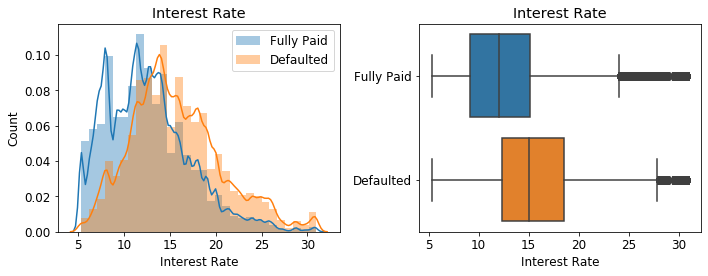

In [28]:
plot_num(df, 'int_rate', 'Interest Rate', True, 30, 10,4)

In [41]:
q1_ir = df['int_rate'].quantile(0.25)
q3_ir = df['int_rate'].quantile(0.75)
iqr_ir = q3_ir - q1_ir
lower_bound_ir = q1_ir - 1.5*iqr_ir
upper_bound_ir = q3_ir + 1.5*iqr_ir
#return df[~((df[col_name] > upper_bound) | (df[col_name] < lower_bound))]#.any(axis=1)]

In [55]:
df_1 = df.copy()
df_1 = df_1[~((df_1['int_rate'] > upper_bound_ir) | (df_1['int_rate'] < lower_bound_ir))];#.any(axis=1)]

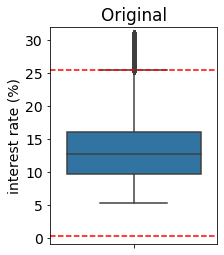

In [56]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(3,4))

sns.boxplot(y='int_rate', data=df)
plt.axhline(lower_bound_ir, color="red", linestyle="--")
plt.axhline(upper_bound_ir , color="red", linestyle="--")
plt.ylim([-1,32])
plt.ylabel('interest rate (%)')
plt.title('Original')

plt.show()

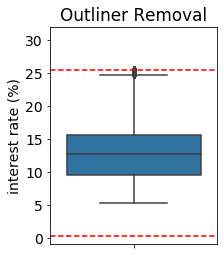

In [58]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(3,4))

sns.boxplot(y='int_rate', data=df_1)
plt.axhline(lower_bound_ir, color="red", linestyle="--")
plt.axhline(upper_bound_ir , color="red", linestyle="--")
plt.ylim([-1,32])
plt.ylabel('interest rate (%)')
plt.title('Outliner Removal')

plt.show()

In [ ]:
def remove_outlier_IQR(df, col_name):
    '''
    remove outliner (above/below 1.5*IQR)
    input: original dataframe, column name
    output: new dataframe (without outliner)
    '''
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return df[~((df[col_name] > upper_bound) | (df[col_name] < lower_bound))]#.any(axis=1)]

after removing outlier:

In [349]:
df_int_rate = df[['int_rate', 'loan_status']].copy()
len(df['int_rate'])

1661978

In [350]:
df_int_rate = remove_outlier_IQR(df_int_rate, 'int_rate')
len(df_int_rate)

1629075

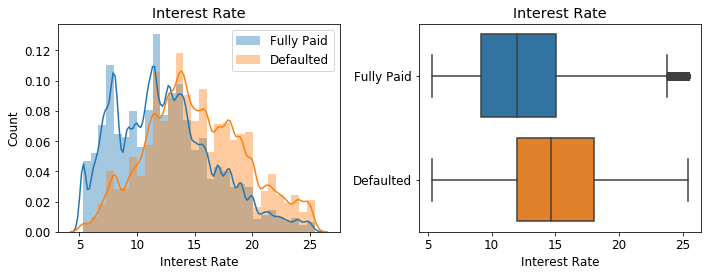

In [351]:
# after remove outlier
plot_num(df_int_rate, 'int_rate', 'Interest Rate', True, 30, 10,4)

The borrowers who are charged off tend to have higher interest rate

**`revol_util`**
- Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

In [352]:
df['revol_util'].describe()

count    1.661978e+06
mean     5.095653e+01
std      2.459892e+01
min      0.000000e+00
25%      3.230000e+01
50%      5.110000e+01
75%      6.990000e+01
max      8.923000e+02
Name: revol_util, dtype: float64

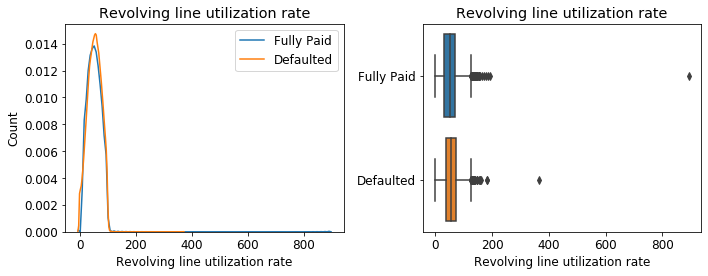

In [353]:
plot_num(df, 'revol_util', 'Revolving line utilization rate', False, 30, 10,4)

remove outlier

In [354]:
df_revol_util = df[['revol_util', 'loan_status']].copy()
print(len(df_revol_util))

1661978


In [355]:
df_revol_util = remove_outlier_IQR(df_revol_util, 'revol_util')
print(len(df_revol_util))

1661886


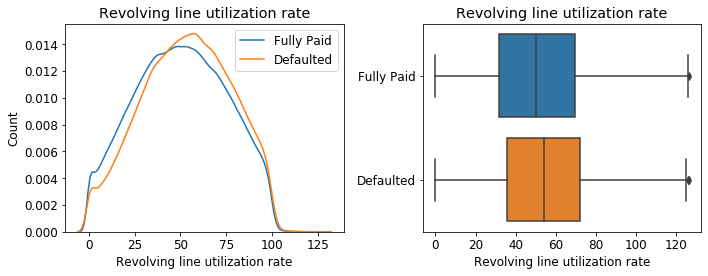

In [356]:
# remove outlier
plot_num(df_revol_util, 'revol_util', 'Revolving line utilization rate', False, 30, 10,4)

The borrowers who are charged off tend to have higher revolving line utilization rate

**`term`**
- The number of payments on the loan. Values are in months and can be either 36 or 60.

In [357]:
df['term'].describe()

count        1661978
unique             2
top        36 months
freq         1250488
Name: term, dtype: object

In [358]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [360]:
df.drop(['term'], axis=1, inplace=True)

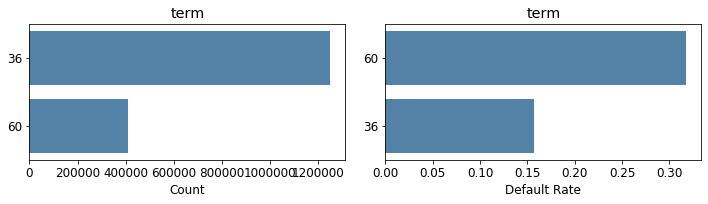

In [361]:
plot_cat(df, 'term_num', 'term', 10,3)

In [362]:
df['term_num'].value_counts()

36    1250488
60     411490
Name: term_num, dtype: int64

Long-term loan tends to default.

**`grade`**
- LC assigned loan grade

In [363]:
df['grade'].head()

id
10224583    C
10148122    A
10149342    B
10129454    B
10149488    B
Name: grade, dtype: object

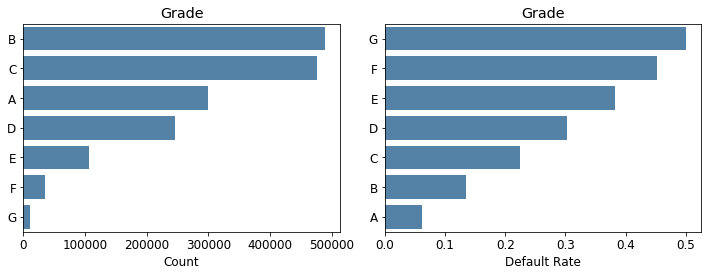

In [364]:
plot_cat(df, 'grade', 'Grade', 10,4)

In [365]:
df['grade_num'] = df['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})

In [366]:
df['grade_num'].unique()

array([5, 7, 6, 4, 3, 2, 1])

In [367]:
df.drop(['grade'], axis=1, inplace=True)

**`emp_length`**
- Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years

In [368]:
df['emp_length'].describe()

count       1557811
unique           11
top       10+ years
freq         551689
Name: emp_length, dtype: object

In [369]:
def finding_emp_length(emp_length):
    if emp_length == '< 1 year':
        return 0
    elif emp_length == '1 year':
        return 1
    elif emp_length == '2 years':
        return 2
    elif emp_length == '3 years':
        return 3
    elif emp_length == '4 years':
        return 4
    elif emp_length == '5 years':
        return 5
    elif emp_length == '6 years':
        return 6
    elif emp_length == '7 years':
        return 7
    elif emp_length == '8 years':
        return 8
    elif emp_length == '9 years':
        return 9
    elif emp_length == '10+ years':
        return 10

    
df['emp_length_num'] = df['emp_length'].apply(finding_emp_length)

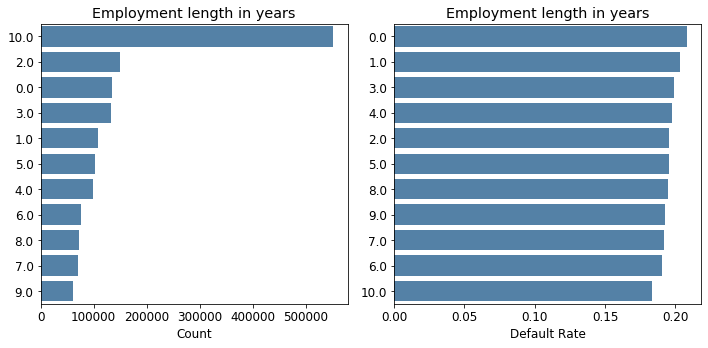

In [370]:
#df.columns#['emp_length'].head()
plot_cat(df, 'emp_length_num', 'Employment length in years',10,5)

In [371]:
df['emp_length_num'].unique()

array([10.,  3.,  4.,  2.,  5.,  6.,  1.,  7.,  8.,  0.,  9., nan])

In [372]:
df.drop(['emp_length'], axis=1, inplace=True)

**`'home_ownership'`**
- The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER

In [373]:
df['home_ownership'].describe()

count      1661978
unique           6
top       MORTGAGE
freq        823619
Name: home_ownership, dtype: object

In [374]:
df['home_ownership'].value_counts()

MORTGAGE    823619
RENT        653953
OWN         183435
ANY            879
OTHER           46
NONE            46
Name: home_ownership, dtype: int64

In [375]:
# drop NONE
df = df[df['home_ownership']!='NONE']
df['home_ownership'].value_counts()

MORTGAGE    823619
RENT        653953
OWN         183435
ANY            879
OTHER           46
Name: home_ownership, dtype: int64

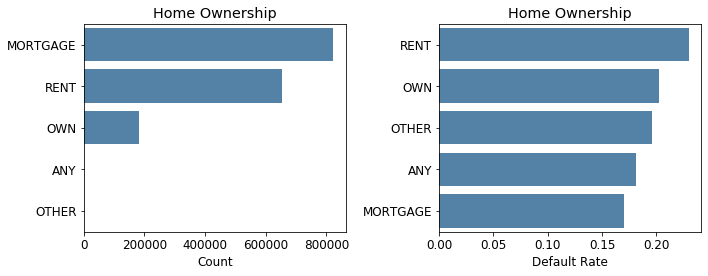

In [376]:
plot_cat(df, 'home_ownership', 'Home Ownership', 10,4)

**`verification_status`**
- Indicates if income was verified by LC, not verified, or if the income source was verified


In [377]:
df['verification_status'].describe()

count             1661932
unique                  3
top       Source Verified
freq               658851
Name: verification_status, dtype: object

In [378]:
df['verification_status'].unique()

array(['Not Verified', 'Verified', 'Source Verified'], dtype=object)

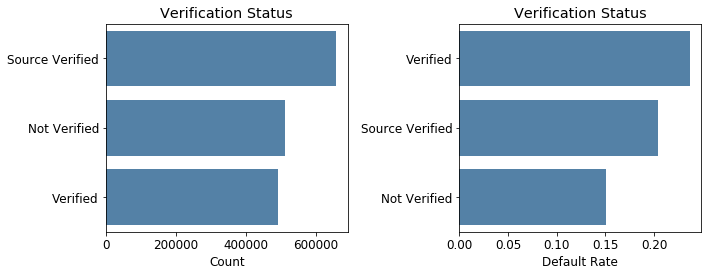

In [379]:
plot_cat(df,'verification_status', 'Verification Status',10,4)

**`purpose`**
- A category provided by the borrower for the loan request.

In [380]:
df['purpose'].describe()

count                1661932
unique                    14
top       debt_consolidation
freq                  960255
Name: purpose, dtype: object

In [381]:
df['purpose'].unique()

array(['other', 'debt_consolidation', 'home_improvement', 'credit_card',
       'major_purchase', 'small_business', 'house', 'moving', 'medical',
       'car', 'vacation', 'renewable_energy', 'wedding', 'educational'],
      dtype=object)

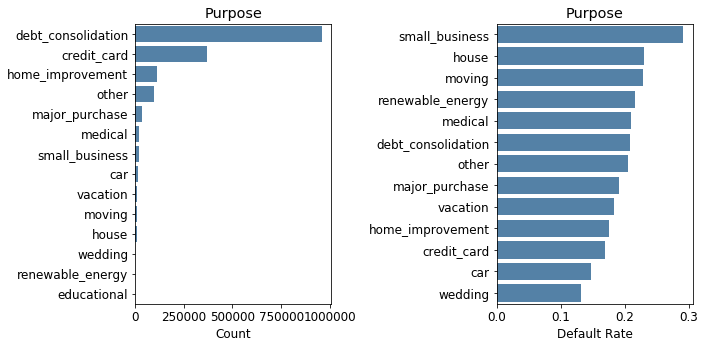

In [382]:
plot_cat(df,'purpose', 'Purpose',10,5)

A row where the loan purpose is **education** is removed since it only appeared once within the data.

In [383]:
print(df['purpose'].value_counts())
df=df[df['purpose']!='educational']


debt_consolidation    960255
credit_card           370963
home_improvement      109499
other                  98018
major_purchase         35340
medical                19488
small_business         17101
car                    16637
vacation               11565
moving                 11390
house                   9271
wedding                 1342
renewable_energy        1061
educational                2
Name: purpose, dtype: int64


**`addr_state`**
- The state provided by the borrower in the loan application

In [384]:
df['addr_state'].describe()

count     1661930
unique         51
top            CA
freq       236119
Name: addr_state, dtype: object

In [385]:
# remove 'IA'
df = df[df['addr_state'] != 'IA']

In [386]:
df['addr_state'].unique()

array(['NY', 'TX', 'MI', 'NC', 'CT', 'FL', 'CA', 'CO', 'NM', 'MA', 'NJ',
       'PA', 'UT', 'SC', 'OH', 'IN', 'AZ', 'DE', 'KY', 'GA', 'WI', 'IL',
       'MO', 'WY', 'TN', 'WA', 'MD', 'VA', 'MN', 'NH', 'NV', 'KS', 'AL',
       'RI', 'OR', 'WV', 'LA', 'VT', 'AR', 'OK', 'HI', 'MT', 'AK', 'SD',
       'DC', 'NE', 'MS', 'ID', 'ME', 'ND'], dtype=object)

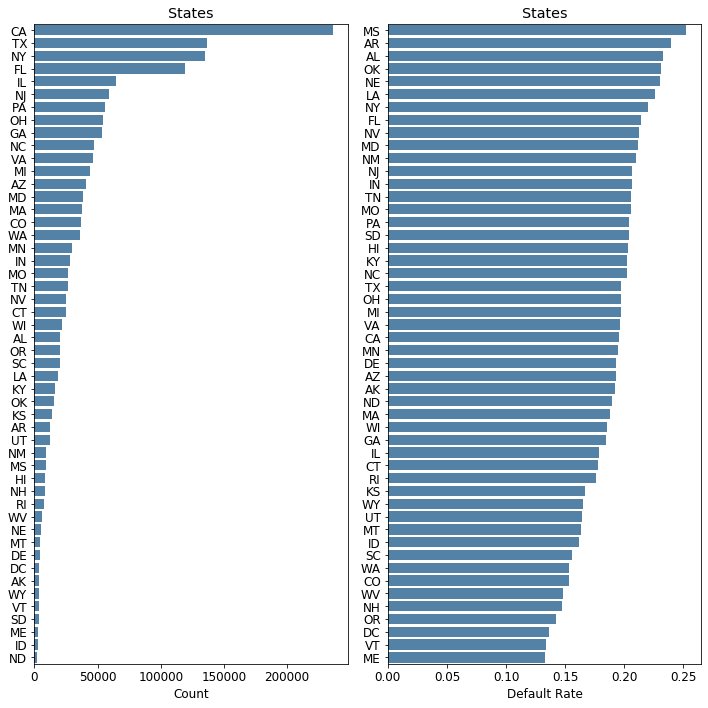

In [62]:
plot_cat(df,'addr_state', 'States',10,10)

**`loan_amnt`**
- The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value

In [387]:
df['loan_amnt'].describe()

count    1.661928e+06
mean     1.461838e+04
std      8.901015e+03
min      1.000000e+03
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

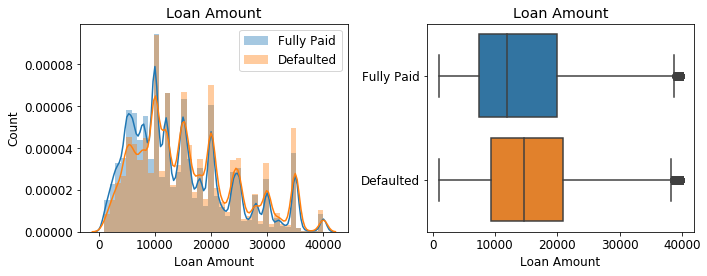

In [388]:
plot_num(df,'loan_amnt', 'Loan Amount', True, 40, 10,4)

remove outlier

In [389]:
df_loan_amnt = df[['loan_amnt', 'loan_status']].copy()
print(len(df_loan_amnt))

1661928


In [390]:
df_loan_amnt = remove_outlier_IQR(df_loan_amnt, 'loan_amnt')
print(len(df_loan_amnt))

1646858


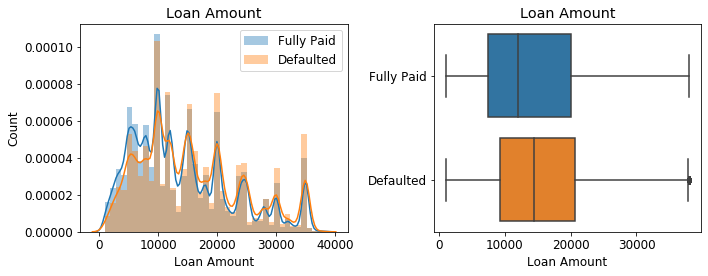

In [391]:
# after remove outliers
plot_num(df_loan_amnt,'loan_amnt', 'Loan Amount', True, 40, 10,4)

**`funded_amnt`**
- The total amount committed to that loan at that point in time.

In [392]:
df['funded_amnt'].describe()

count    1.661928e+06
mean     1.461809e+04
std      8.900801e+03
min      1.000000e+03
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: funded_amnt, dtype: float64

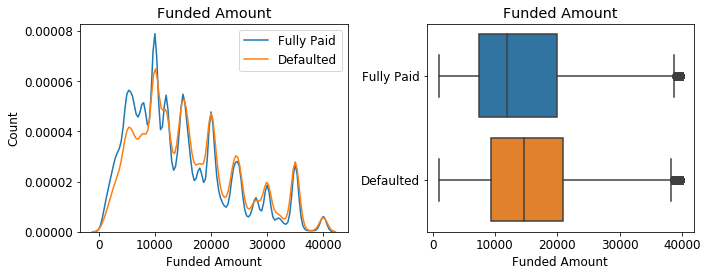

In [393]:
plot_num(df, 'funded_amnt', 'Funded Amount',False, 30, 10,4)

In [394]:
df_funded_amnt = df[['funded_amnt', 'loan_status']].copy()
print(len(df_funded_amnt))

1661928


In [395]:
df_funded_amnt = remove_outlier_IQR(df_funded_amnt, 'funded_amnt')
print(len(df_funded_amnt))

1646858


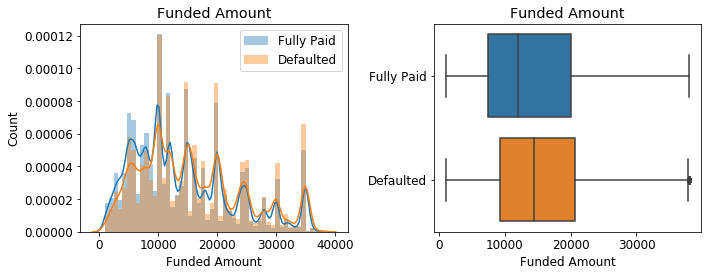

In [396]:
# remove outlier
plot_num(df_funded_amnt, 'funded_amnt', 'Funded Amount',True, 50, 10,4)

**`installment`**
- The monthly payment owed by the borrower if the loan originates.

In [397]:
df['installment'].describe()

count    1.661928e+06
mean     4.423696e+02
std      2.656232e+02
min      4.930000e+00
25%      2.499800e+02
50%      3.761200e+02
75%      5.873400e+02
max      1.719830e+03
Name: installment, dtype: float64

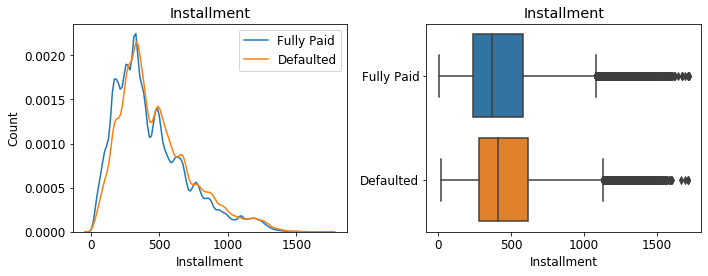

In [398]:
plot_num(df,'installment', 'Installment',False, 30, 10,4)

remove outlier

In [399]:
df_installment = df[['installment', 'loan_status']].copy()
print(len(df_installment))

1661928


In [400]:
df_installment = remove_outlier_IQR(df_installment, 'installment')
print(len(df_installment))

1609893


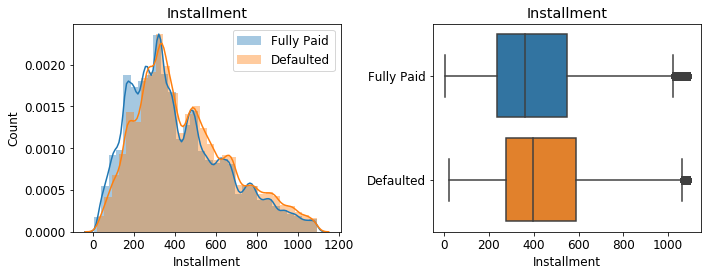

In [401]:
plot_num(df_installment,'installment', 'Installment',True, 30, 10,4)

**`annual_inc`**
- The self-reported annual income provided by the borrower during registration.

In [402]:
df['annual_inc'].describe()

count    1.661928e+06
mean     7.717326e+04
std      1.115929e+05
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.200000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

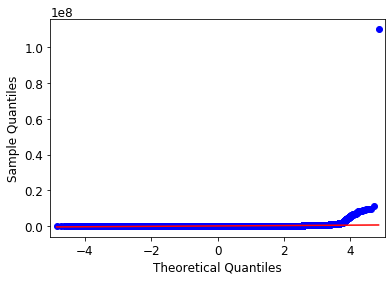

In [403]:
sm.qqplot(df['annual_inc'], line='s')#, line='s')
#plt.ylim(0,0.25e7)
plt.show()

not a normal distribution

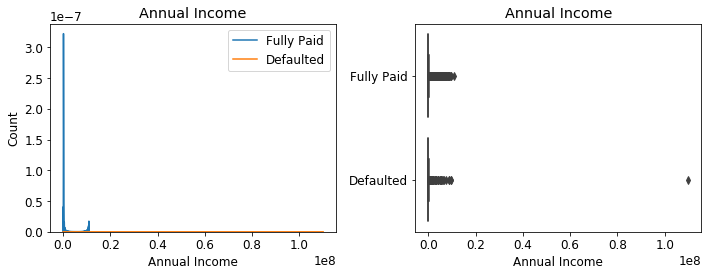

In [404]:
# without log transform
plot_num(df,'annual_inc', 'Annual Income',False, 30, 10,4)

Annual income ranges from 0 to 110,000,000, with a median of 68,000. Because of the large range of annual incomes, we can take a log transform of the annual income variable.

In [405]:
# log transform
df['log_annual_inc'] = df['annual_inc'].apply(lambda x: np.log10(x))

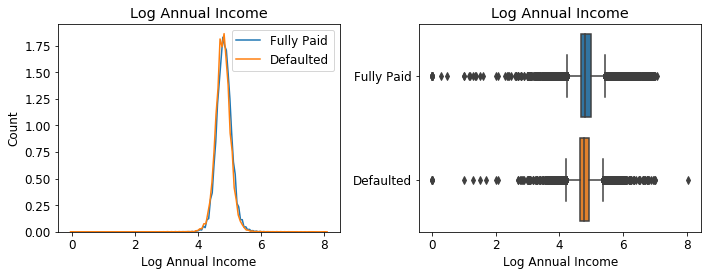

In [406]:
# after log transform
plot_num(df,'log_annual_inc', 'Log Annual Income', False, 30, 10,4)

remove outlier

In [407]:
df_log_annual_inc = df[['log_annual_inc', 'loan_status']].copy()
print(len(df_log_annual_inc))

1661928


In [408]:
df_log_annual_inc = remove_outlier_IQR(df_log_annual_inc, 'log_annual_inc')
print(len(df_log_annual_inc))

1631833


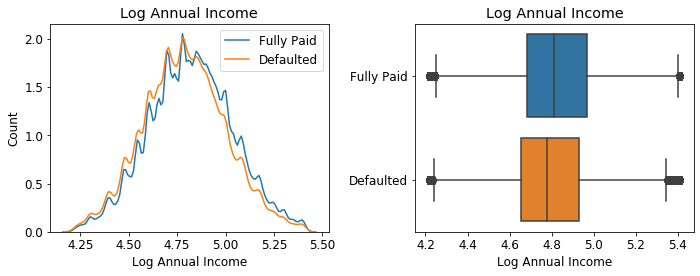

In [409]:
plot_num(df_log_annual_inc ,'log_annual_inc', 'Log Annual Income',False, 30, 10,4)

**`dti`**
- A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

In [410]:
df['dti'].describe()

count    1.661081e+06
mean     1.862214e+01
std      1.257372e+01
min     -1.000000e+00
25%      1.194000e+01
50%      1.782000e+01
75%      2.439000e+01
max      9.990000e+02
Name: dti, dtype: float64

Based on the definition, dti should not be less than 0

In [411]:
df=df[df['dti']>0]

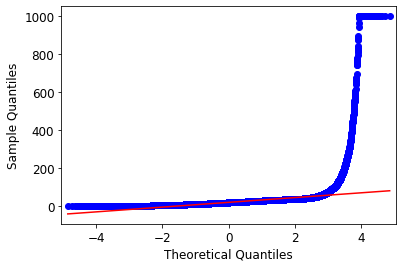

In [412]:
sm.qqplot(df['dti'], line='s')
#plt.ylim(0,0.25e7)
plt.show()

not a normal distribution

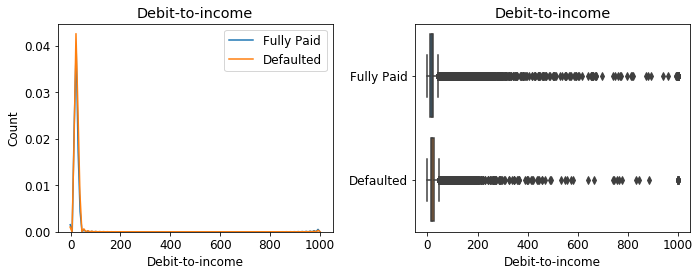

In [413]:
plot_num(df,'dti', 'Debit-to-income',False,30, 10,4)

In [414]:
df['log_dti'] = df['dti'].apply(lambda x: np.log10(x))

In [415]:
# check missing values
df['log_dti'].isnull().sum()

0

In [416]:
#Drop the row where at least one element is missing.
df['log_dti'].dropna(axis=0, inplace=True)

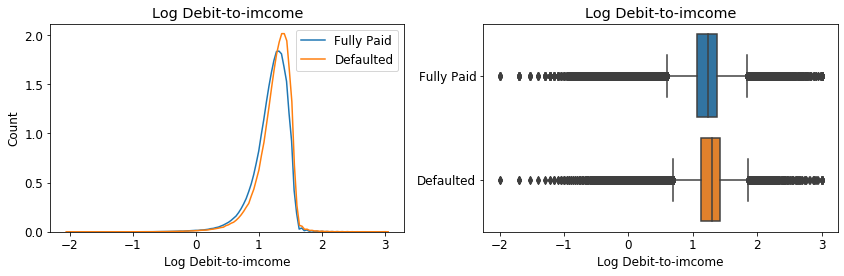

In [417]:
# after log transform
plot_num(df,'log_dti', 'Log Debit-to-imcome',False, 30, 12,4)

remove outlier

1660159
1601317


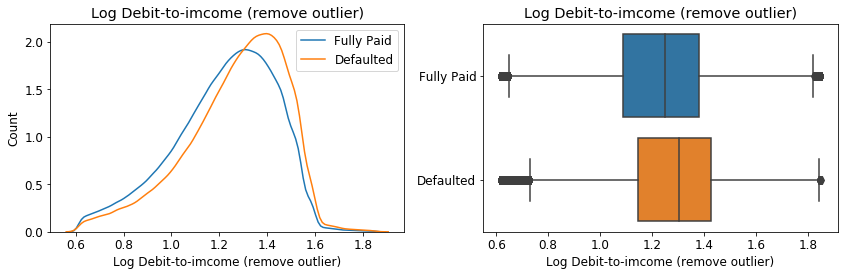

In [418]:
df_log_dti = df[['log_dti', 'loan_status']].copy()
print(len(df_log_dti))

df_log_dti = remove_outlier_IQR(df_log_dti, 'log_dti')
print(len(df_log_dti))

plot_num(df_log_dti ,'log_dti', 'Log Debit-to-imcome (remove outlier)',False, 30, 12,4)

**`revol_bal`**
- Total credit revolving balance

In [419]:
df['revol_bal'].describe()

count    1.660159e+06
mean     1.635381e+04
std      2.253422e+04
min      0.000000e+00
25%      5.943000e+03
50%      1.115400e+04
75%      1.982400e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

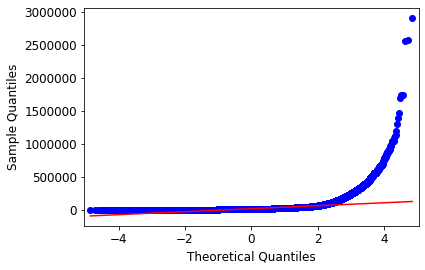

In [420]:
sm.qqplot(df['revol_bal'], line='s')
#plt.ylim(0,0.25e7)
plt.show()

not a normal distribution

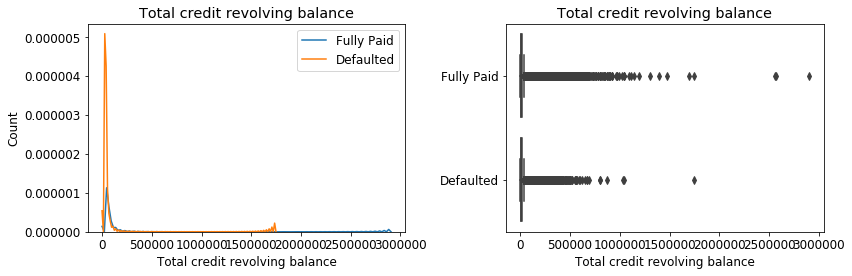

In [421]:
plot_num(df,'revol_bal', 'Total credit revolving balance',False, 30, 12,4)

In [425]:
df['log_revol_bal'] = df['revol_bal'].apply(lambda x: np.log10(x))

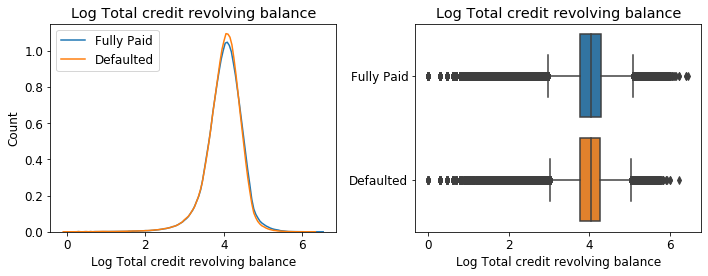

In [426]:
plot_num(df,'log_revol_bal', 'Log Total credit revolving balance',False, 30,10,4)

remove outlier

1660159
1601816


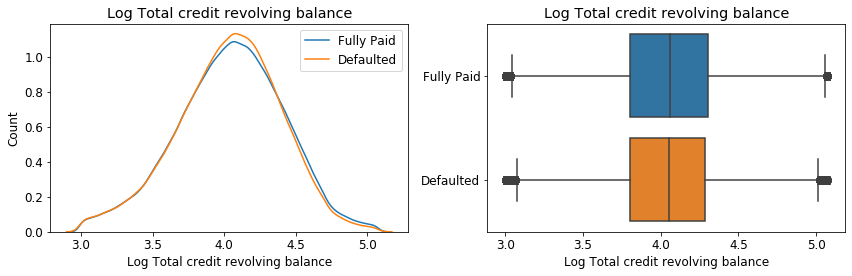

In [427]:
df_log_revol_bal = df[['log_revol_bal', 'loan_status']].copy()
print(len(df_log_revol_bal))

df_log_revol_bal = remove_outlier_IQR(df_log_revol_bal , 'log_revol_bal')
print(len(df_log_revol_bal))

plot_num(df_log_revol_bal ,'log_revol_bal', 'Log Total credit revolving balance',False, 30, 12,4)

**`delinq_2yrs`**
- The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

In [428]:
df['delinq_2yrs'].describe()

count    1.660159e+06
mean     3.195110e-01
std      8.849165e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.200000e+01
Name: delinq_2yrs, dtype: float64

In [429]:
df['delinq_2yrs'].unique()

array([ 1.,  0.,  2.,  3.,  4.,  6.,  5.,  7.,  8.,  9., 15., 11., 13.,
       10., 12., 17., 18., 29., 24., 14., 21., 22., 19., 16., 30., 26.,
       20., 27., 39., 42., 25., 28., 32., 36., 23.])

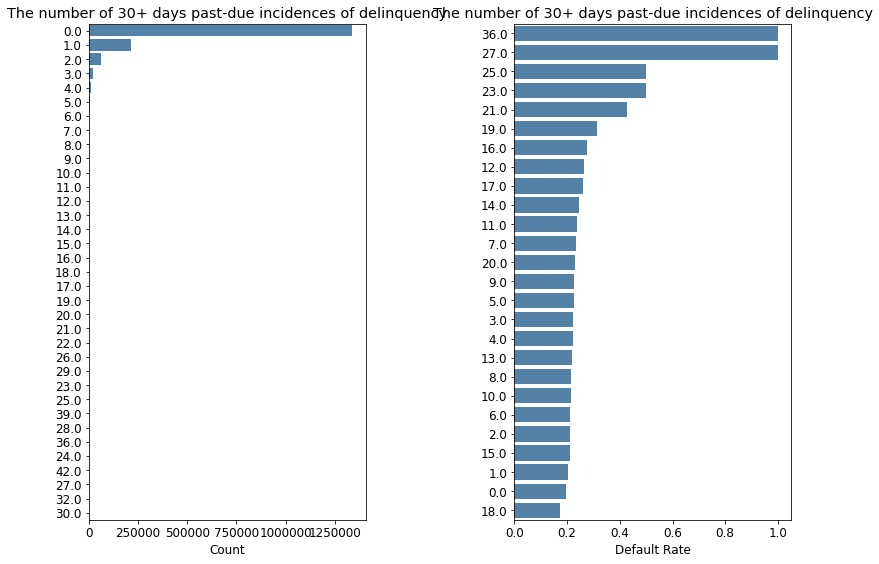

In [430]:
plot_cat(df,'delinq_2yrs', 'The number of 30+ days past-due incidences of delinquency',12,8)

(0, 1000)

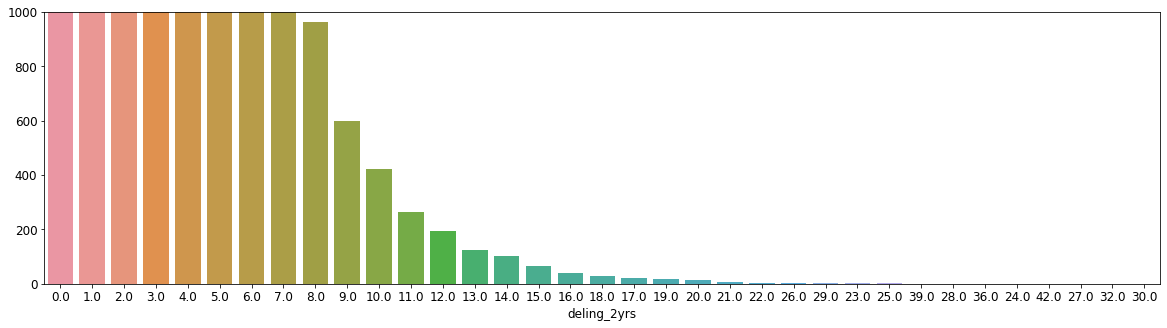

In [431]:
plt.figure(figsize=(20,5))
sns.countplot(x='delinq_2yrs', data = df,\
              order = df['delinq_2yrs'].value_counts().index)
plt.xlabel('deling_2yrs')
plt.ylabel('Count')
plt.ylabel('')
plt.ylim(0,1000)
#ax1.set_title(full_name)

In [432]:
df['log_delinq_2yrs'] = df['delinq_2yrs'].apply(lambda x: np.log10(x))

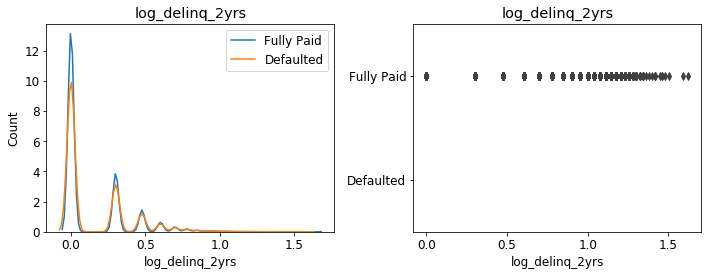

In [433]:
plot_num(df,'log_delinq_2yrs', 'log_delinq_2yrs',False, 30, 10,4)

1660159
1660159


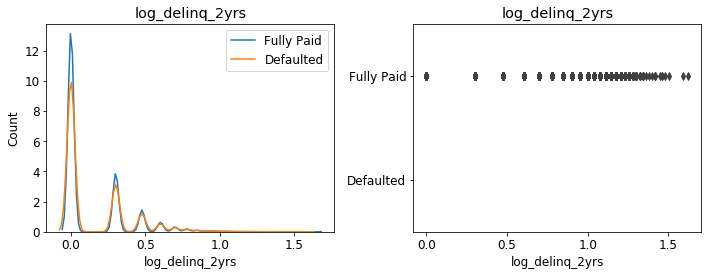

In [434]:
df_log_delinq_2yrs = df[['log_delinq_2yrs', 'loan_status']].copy()
print(len(df_log_delinq_2yrs))

df_log_delinq_2yrs = remove_outlier_IQR(df_log_delinq_2yrs , 'log_delinq_2yrs')
print(len(df_log_delinq_2yrs))

plot_num(df_log_delinq_2yrs ,'log_delinq_2yrs', 'log_delinq_2yrs',False,30,10,4)

**`open_acc`**
- The number of open credit lines in the borrower's credit file.

In [435]:
df['open_acc'].describe()

count    1.660159e+06
mean     1.167105e+01
std      5.556631e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      9.000000e+01
Name: open_acc, dtype: float64

In [436]:
df['open_acc'].unique()

array([ 9., 17., 14., 15.,  3., 12.,  6.,  8.,  4., 10.,  7., 16., 29.,
        5., 11., 13., 20., 21., 19., 30., 27., 18., 25., 23., 22., 24.,
       40., 26.,  2., 28., 31.,  1., 37., 32., 33., 42., 41., 34., 39.,
       36., 35., 45., 38., 49., 53., 51., 43., 62., 44., 46., 48., 50.,
       52., 54., 47., 76., 58., 55., 84., 75., 61., 65., 67., 57., 66.,
       68., 70., 60., 56., 82., 63., 59., 64., 79., 74., 90., 72., 77.,
       81., 71., 69., 80., 86., 88.])

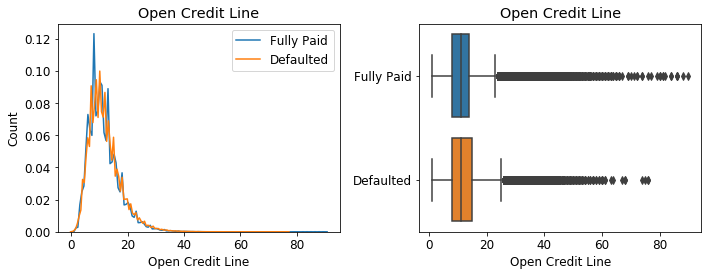

In [437]:
plot_num(df,'open_acc', 'Open Credit Line',False,30,10,4)

remove outlier

1660159
1599641


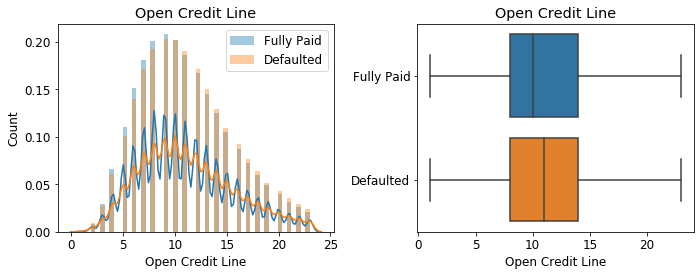

In [438]:
df_open_acc = df[['open_acc', 'loan_status']].copy()
print(len(df_open_acc))

df_open_acc = remove_outlier_IQR(df_open_acc , 'open_acc')
print(len(df_open_acc))

plot_num(df_open_acc ,'open_acc', 'Open Credit Line',True,50,10,4)

**`pub_rec`**
- Number of derogatory public records

In [439]:
df['pub_rec'].describe()

count    1.660159e+06
mean     2.157811e-01
std      6.028247e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.600000e+01
Name: pub_rec, dtype: float64

In [440]:
df['pub_rec'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  9.,  8.,  7., 11., 49., 10.,
       54., 12., 18., 19., 16., 15., 14., 40., 63., 13., 21., 34., 17.,
       23., 28., 20., 86., 22., 46., 37., 31., 47., 24., 45., 25., 61.,
       32., 44., 52.])

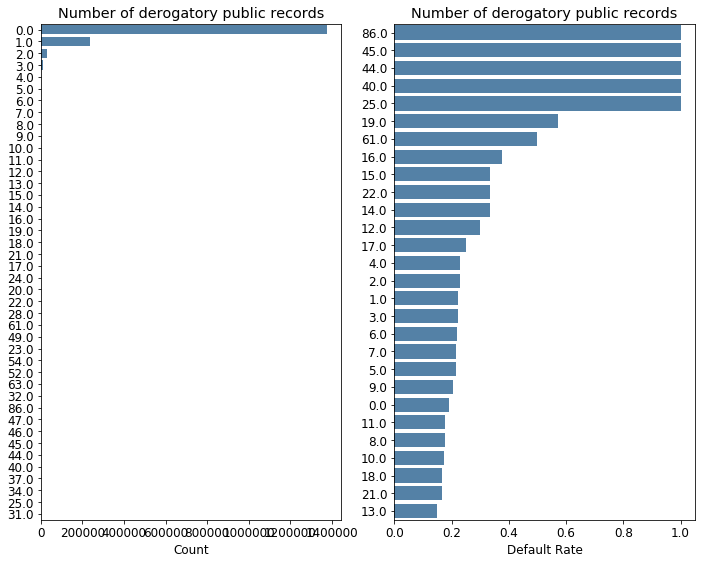

In [441]:
plot_cat(df,'pub_rec', 'Number of derogatory public records', 10,8)

**`fico_range_high`**

**`fico_range_low`**

FICO score usually comes in a range, so the data included feature 'fico_range_high' and 'fico_range_low'. Since these features are correlated, we just take the average between these two.

In [442]:
df['fico'] = (df['fico_range_high']  + df['fico_range_high'])/2

In [443]:
df['fico'].describe()

count    1.660159e+06
mean     7.006655e+02
std      3.214476e+01
min      6.640000e+02
25%      6.740000e+02
50%      6.940000e+02
75%      7.140000e+02
max      8.500000e+02
Name: fico, dtype: float64

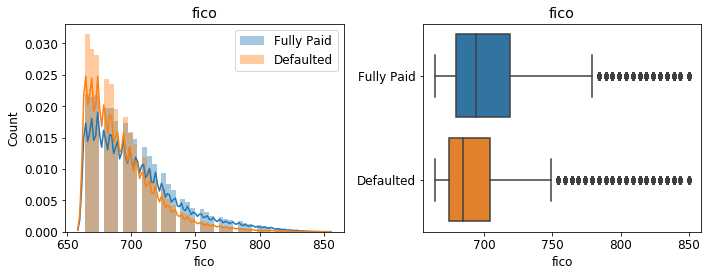

In [444]:
plot_num(df,'fico', 'fico',True, 50, 10,4)

remove outlier

1660159
1600444


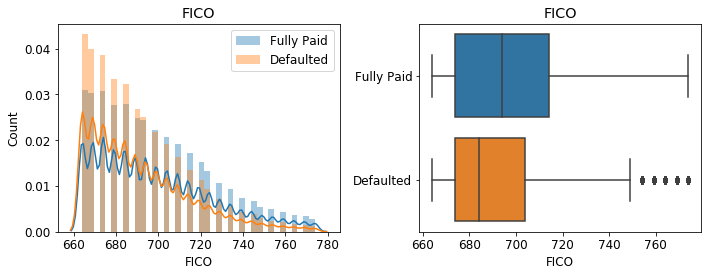

In [445]:
df_fico = df[['fico', 'loan_status']].copy()
print(len(df_fico))

df_fico = remove_outlier_IQR(df_fico , 'fico')
print(len(df_fico))

plot_num(df_fico ,'fico', 'FICO',True, 40,10,4)

**`total_pymnt`**

In [446]:
df['total_pymnt'].describe()

count    1.660159e+06
mean     1.517665e+04
std      1.060117e+04
min      1.000000e+01
25%      6.975299e+03
50%      1.235053e+04
75%      2.110434e+04
max      6.450823e+04
Name: total_pymnt, dtype: float64

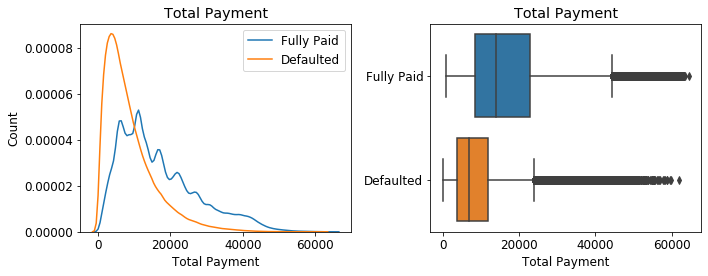

In [447]:
plot_num(df,'total_pymnt', 'Total Payment',False, 30, 10,4)

remove outlier

1660159
1624333


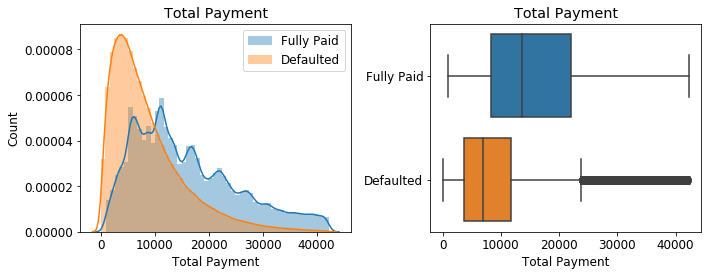

In [448]:
df_total_pymnt = df[['total_pymnt', 'loan_status']].copy()
print(len(df_total_pymnt))

df_total_pymnt = remove_outlier_IQR(df_total_pymnt , 'total_pymnt')
print(len(df_total_pymnt))

plot_num(df_total_pymnt ,'total_pymnt', 'Total Payment', True, 50, 10,4)

**`recoveries`**
- post charge off gross recovery

In [449]:
df['recoveries'].describe()

count    1.660159e+06
mean     2.639165e+02
std      1.026683e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.985955e+04
Name: recoveries, dtype: float64

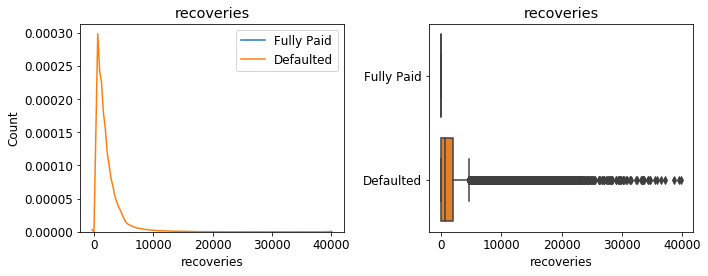

In [450]:
plot_num(df,'recoveries', 'recoveries',False, 30, 10,4)

remove outlier

327301
310984


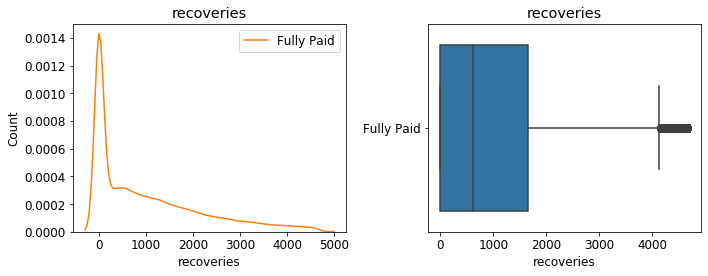

In [451]:
df_recoveries = df[df['loan_status']=='Charged Off'][['recoveries', 'loan_status']].copy()
#df_recoveries = df[['recoveries', 'loan_status']].copy()
print(len(df_recoveries))

df_recoveries = remove_outlier_IQR(df_recoveries , 'recoveries')
print(len(df_recoveries))

plot_num(df_recoveries ,'recoveries', 'recoveries',False, 30, 10,4)

borrowers who paid off on time does not have recoveries feature. Remove this feature for ML

**`Annual_ROI`**
Net Annual Return 

In [452]:
df['Annual_ROI'].describe()

count    1.660159e+06
mean    -1.376784e-02
std      2.705118e-01
min     -1.000000e+00
25%      4.047768e-02
50%      7.060419e-02
75%      1.057060e-01
max      3.837749e+00
Name: Annual_ROI, dtype: float64

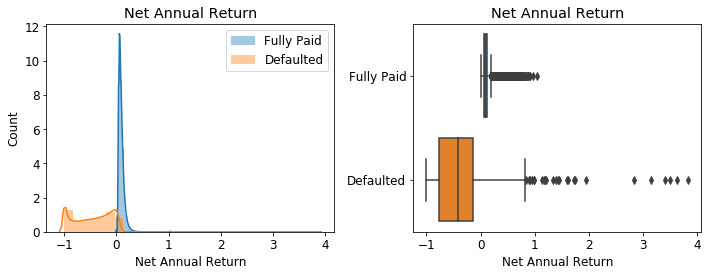

In [453]:
plot_num(df,'Annual_ROI', 'Net Annual Return', True, 30, 10,4)

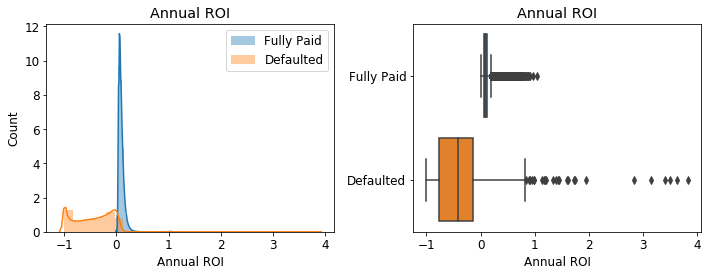

In [454]:
plot_num(df,'Annual_ROI', 'Annual ROI',True, 30, 10,4)

In [456]:

df['Log_Annual_ROI'] = df['Annual_ROI'].apply(lambda x: np.log10(x) if x>0 else np.log10(-x))

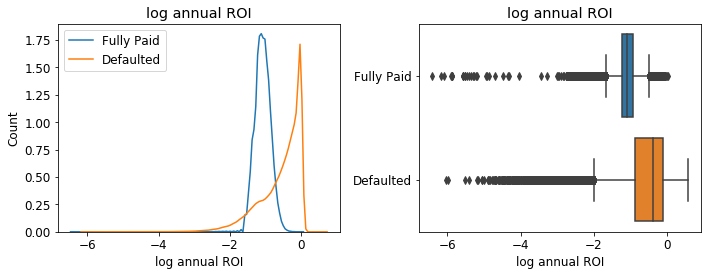

In [457]:
plot_num(df,'Log_Annual_ROI', 'log annual ROI',False, 30, 10,4)

### Summary

In [458]:
df.to_csv('LC_preprocessing.csv') # after cleanup (but not remove outlier)

prepare ML data

In [464]:
# pick up columns for ML
col_cal = ['home_ownership', 'verification_status', 'purpose', 'addr_state','pub_rec']
col_num = ['term_num','grade_num','loan_period','int_rate', 'revol_util','loan_amnt', 'funded_amnt', 'installment','open_acc','fico','total_pymnt',\
          'log_annual_inc', 'log_dti','log_revol_bal', 'log_delinq_2yrs', 'emp_length_num', 'Log_Annual_ROI']
col_date = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']
col_target = ['target']

In [465]:
col_set = col_cal + col_num + col_date + col_target
print(col_set)

['home_ownership', 'verification_status', 'purpose', 'addr_state', 'pub_rec', 'term_num', 'grade_num', 'loan_period', 'int_rate', 'revol_util', 'loan_amnt', 'funded_amnt', 'installment', 'open_acc', 'fico', 'total_pymnt', 'log_annual_inc', 'log_dti', 'log_revol_bal', 'log_delinq_2yrs', 'emp_length_num', 'Log_Annual_ROI', 'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'target']


In [466]:
print(len(col_set))

26


In [467]:
df_ML = df[col_set].copy()

In [468]:
# remove missing values in row
df_ML.dropna(axis=0, inplace=True)

In [469]:
df_ML.reset_index(drop=True, inplace=True)
df_ML.head()

,home_ownership,verification_status,purpose,addr_state,pub_rec,term_num,grade_num,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,log_delinq_2yrs,emp_length_num,Log_Annual_ROI,issue_d,earliest_cr_line,last_pymnt_d,target
0,MORTGAGE,Not Verified,other,NY,0.0,36,5,26.021068,14.98,66.2,11100.0,11100.0,384.68,9.0,694.0,13575.640006,4.954243,0.571709,3.820792,0.0,10.0,-1.011914,2013-12-01,2001-06-01,2016-02-01,0
1,MORTGAGE,Not Verified,debt_consolidation,TX,0.0,36,7,29.996509,7.62,55.7,12000.0,12000.0,373.94,17.0,709.0,13397.539998,4.984527,1.100715,4.122150,-inf,3.0,-1.346243,2013-12-01,2003-09-01,2016-06-01,0
2,OWN,Verified,debt_consolidation,MI,0.0,36,6,30.982156,10.99,61.2,27050.0,27050.0,885.46,14.0,734.0,31752.530000,4.740363,1.359266,4.563932,-inf,10.0,-1.193486,2013-12-01,1986-10-01,2016-07-01,0
3,RENT,Not Verified,debt_consolidation,NC,0.0,36,6,27.992361,10.99,24.0,12000.0,12000.0,392.81,15.0,724.0,13988.609996,4.778151,0.664642,3.853516,-inf,4.0,-1.167860,2013-12-01,2009-12-01,2016-04-01,0
4,MORTGAGE,Source Verified,home_improvement,TX,0.0,36,6,9.002238,10.99,16.1,4800.0,4800.0,157.13,3.0,759.0,5157.519457,4.597695,0.396199,3.616581,-inf,2.0,-0.997843,2013-12-01,1995-08-01,2014-09-01,0


In [470]:
df_ML.shape

(1556959, 26)

In [471]:
df_ML[col_num].isnull().sum()

term_num           0
grade_num          0
loan_period        0
int_rate           0
revol_util         0
loan_amnt          0
funded_amnt        0
installment        0
open_acc           0
fico               0
total_pymnt        0
log_annual_inc     0
log_dti            0
log_revol_bal      0
log_delinq_2yrs    0
emp_length_num     0
Log_Annual_ROI     0
dtype: int64

In [472]:
df_ML[col_num].head()

,term_num,grade_num,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,log_delinq_2yrs,emp_length_num,Log_Annual_ROI
0,36,5,26.021068,14.98,66.2,11100.0,11100.0,384.68,9.0,694.0,13575.640006,4.954243,0.571709,3.820792,0.0,10.0,-1.011914
1,36,7,29.996509,7.62,55.7,12000.0,12000.0,373.94,17.0,709.0,13397.539998,4.984527,1.100715,4.122150,-inf,3.0,-1.346243
2,36,6,30.982156,10.99,61.2,27050.0,27050.0,885.46,14.0,734.0,31752.530000,4.740363,1.359266,4.563932,-inf,10.0,-1.193486
3,36,6,27.992361,10.99,24.0,12000.0,12000.0,392.81,15.0,724.0,13988.609996,4.778151,0.664642,3.853516,-inf,4.0,-1.167860
4,36,6,9.002238,10.99,16.1,4800.0,4800.0,157.13,3.0,759.0,5157.519457,4.597695,0.396199,3.616581,-inf,2.0,-0.997843


In [202]:
df_ML_LP = remove_outlier_IQR(df_ML, 'loan_period')
df_ML_LP.shape

(1557709, 26)

remove outlier

In [474]:
df_ML_rm = df_ML.copy()

In [475]:
for feature in col_num:
    df_ML_rm = remove_outlier_IQR(df_ML_rm, feature)

In [476]:
df_ML_rm.shape

(1040120, 26)

In [477]:
df_ML.shape

(1556959, 26)

In [478]:
df_ML_rm[col_num + col_target].head()

,term_num,grade_num,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,log_delinq_2yrs,emp_length_num,Log_Annual_ROI,target
1,36,7,29.996509,7.62,55.7,12000.0,12000.0,373.94,17.0,709.0,13397.539998,4.984527,1.100715,4.122150,-inf,3.0,-1.346243,0
2,36,6,30.982156,10.99,61.2,27050.0,27050.0,885.46,14.0,734.0,31752.530000,4.740363,1.359266,4.563932,-inf,10.0,-1.193486,0
3,36,6,27.992361,10.99,24.0,12000.0,12000.0,392.81,15.0,724.0,13988.609996,4.778151,0.664642,3.853516,-inf,4.0,-1.167860,0
5,36,7,37.027454,6.62,21.6,12000.0,12000.0,368.45,12.0,764.0,13263.954639,5.021189,1.147676,4.119520,-inf,10.0,-1.481653,0
6,36,6,37.027454,12.85,81.9,14000.0,14000.0,470.71,6.0,674.0,16945.318783,4.944483,1.000868,3.566555,0.0,4.0,-1.194953,0


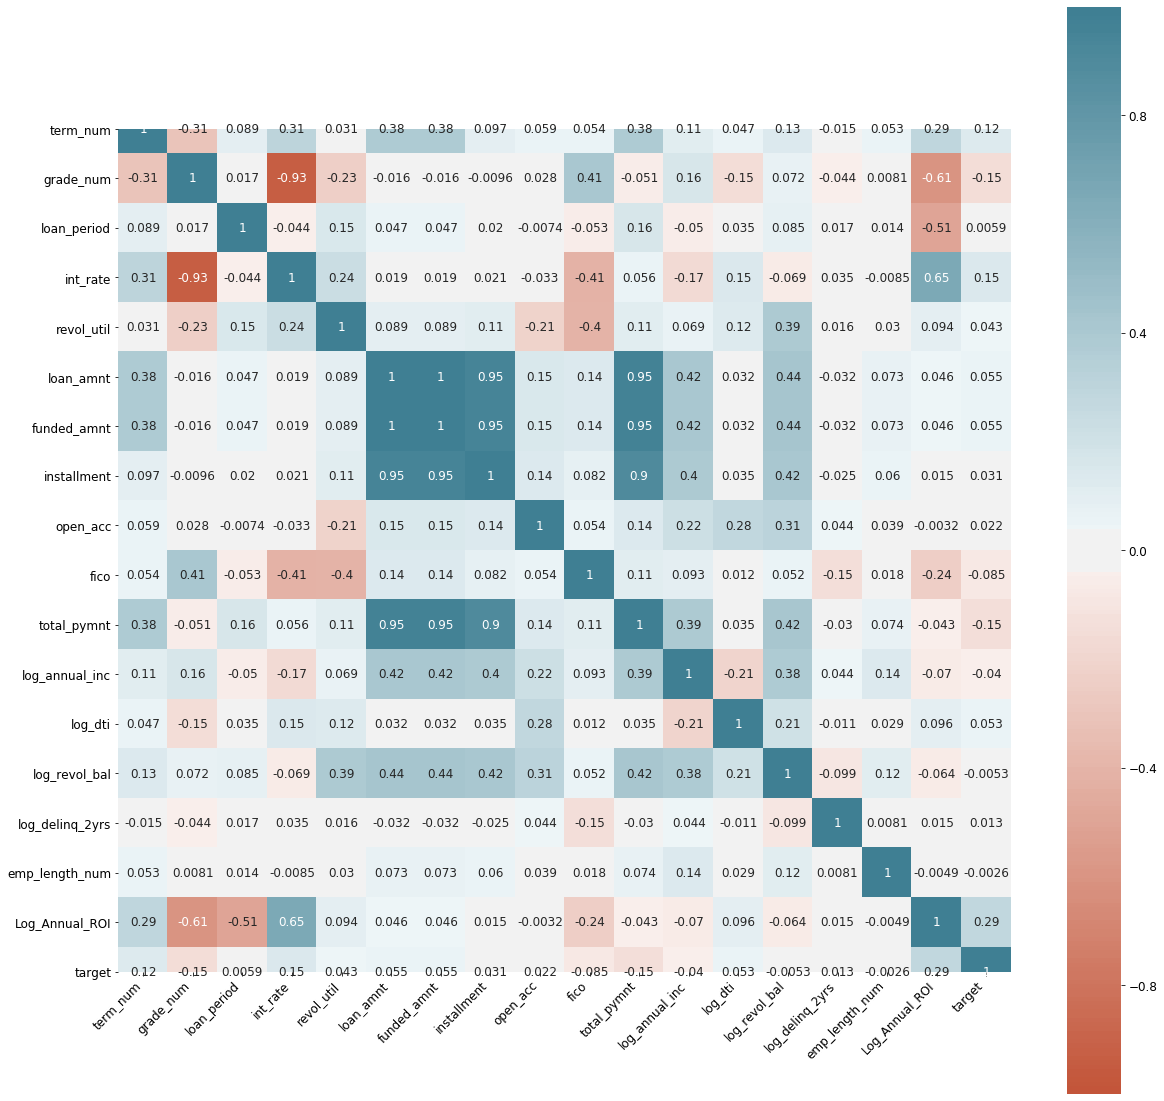

In [479]:
# heatmap

#sns.heatmap(df_ML[col_num].corr(), annot = True,  cbar=True)
#
plt.figure(figsize=(20,20))

ax = sns.heatmap(
    df_ML_rm[col_num+col_target].corr(), 
    vmin=-1, vmax=1, center=0,annot = True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [480]:
df_ML_rm.to_csv('LC_ML_prep.csv')